# Chess Engine with PyTorch

## Imports

In [2]:
import os
import numpy as np 
import time
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader     
from chess import pgn 
from tqdm import tqdm 
import chess
from auxiliary_func import create_input_and_value, encode_moves
from dataset import ChessDataset
from model import ChessModel
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt

# Data preprocessing

## Load data

In [3]:
def load_pgn(file_path, limit_per_file=None):
    games = []
    with open(file_path, 'r') as pgn_file:
        count = 0
        while True:
            game = pgn.read_game(pgn_file)
            if game is None:
                break
            games.append(game)
            count += 1
            if limit_per_file is not None and count >= limit_per_file:
                break
    return games

# Lister tous les fichiers PGN
files = [file for file in os.listdir("../data/pgn") if file.endswith(".pgn")]
LIMIT_OF_FILES = min(len(files), 28)
LIMIT_PER_FILE = 500  # Limite de parties par fichier

# Charger les fichiers avec une barre de progression
games = []
for i, file in enumerate(tqdm(files[:LIMIT_OF_FILES], desc="Loading PGN files")):
    games.extend(load_pgn(f"../data/pgn/{file}", limit_per_file=LIMIT_PER_FILE))

print(f"GAMES PARSED: {len(games)}")

Loading PGN files: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

GAMES PARSED: 500


In [4]:
print(f"GAMES PARSED: {len(games)}")

GAMES PARSED: 500


## Convert data into tensors

In [5]:
X, y_policy_str, y_value = create_input_and_value(games)

print(f"NUMBER OF SAMPLES: {len(y_policy_str)}")

X = X[0:2500000]
y_policy_str = y_policy_str[0:2500000]
y_value = y_value[0:2500000]

y_policy, move_to_int = encode_moves(y_policy_str)
num_classes = len(move_to_int)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_policy_tensor = torch.tensor(y_policy, dtype=torch.long)
y_value_tensor = torch.tensor(y_value, dtype=torch.float32)

NUMBER OF SAMPLES: 43532


# Preliminary actions

In [ ]:
# Create Dataset and DataLoader
dataset = ChessDataset(X_tensor, y_policy_tensor, y_value_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=cpu_count())

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Model Initialization
model = ChessModel(num_classes=num_classes).to(device)

# Pour la tête policy (classification du coup)
criterion_policy = nn.CrossEntropyLoss()
# Pour la tête value (régression de la valeur de la position)
criterion_value  = nn.MSELoss()

# Poids relatif de la value dans la loss totale
lambda_value = 1.0

optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using device: cuda


# Training

Epoch 1/50 — avg loss: 6.6582


Epoch 2/50 — avg loss: 6.1658


Epoch 3/50 — avg loss: 6.0649


Epoch 4/50 — avg loss: 5.9881


Epoch 5/50 — avg loss: 5.9244


Epoch 6/50 — avg loss: 5.8661


Epoch 7/50 — avg loss: 5.8117


Epoch 8/50 — avg loss: 5.7615


Epoch 9/50 — avg loss: 5.7018


Epoch 10/50 — avg loss: 5.6420


Epoch 11/50 — avg loss: 5.5768


Epoch 12/50 — avg loss: 5.5171


Epoch 13/50 — avg loss: 5.4525


Epoch 14/50 — avg loss: 5.3853


Epoch 15/50 — avg loss: 5.3157


Epoch 16/50 — avg loss: 5.2509


Epoch 17/50 — avg loss: 5.1840


Epoch 18/50 — avg loss: 5.1202


Epoch 19/50 — avg loss: 5.0558


Epoch 20/50 — avg loss: 4.9942


Epoch 21/50 — avg loss: 4.9306


Epoch 22/50 — avg loss: 4.8611


Epoch 23/50 — avg loss: 4.8025


Epoch 24/50 — avg loss: 4.7339


Epoch 25/50 — avg loss: 4.6723


Epoch 26/50 — avg loss: 4.6037


Epoch 27/50 — avg loss: 4.5451


Epoch 28/50 — avg loss: 4.4783


Epoch 29/50 — avg loss: 4.4214


Epoch 30/50 — avg loss: 4.3640


Epoch 31/50 — avg loss: 4.3098


Epoch 32/50 — avg loss: 4.2514


Epoch 33/50 — avg loss: 4.2022


Epoch 34/50 — avg loss: 4.1517


Epoch 35/50 — avg loss: 4.0968


Epoch 36/50 — avg loss: 4.0521


Epoch 37/50 — avg loss: 3.9996


Epoch 38/50 — avg loss: 3.9536


Epoch 39/50 — avg loss: 3.9064


Epoch 40/50 — avg loss: 3.8609


Epoch 41/50 — avg loss: 3.8149


Epoch 42/50 — avg loss: 3.7748


Epoch 43/50 — avg loss: 3.7305


Epoch 44/50 — avg loss: 3.6848


Epoch 45/50 — avg loss: 3.6487


Epoch 46/50 — avg loss: 3.6095


Epoch 47/50 — avg loss: 3.5575


Epoch 48/50 — avg loss: 3.5181


Epoch 49/50 — avg loss: 3.4828


Epoch 50/50 — avg loss: 3.4434


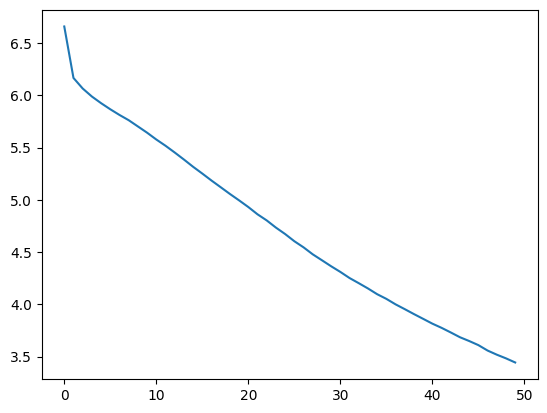

In [ ]:
num_epochs = 50
model.to(device)
epoch_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

    for inputs, labels_policy, labels_value in pbar:
        inputs        = inputs.to(device, non_blocking=True)
        labels_policy = labels_policy.to(device, non_blocking=True)
        labels_value  = labels_value.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits, values = model(inputs)

        Lp   = criterion_policy(logits, labels_policy)
        Lv   = criterion_value(values, labels_value)
        loss = Lp + lambda_value * Lv

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss / (pbar.n + 1), refresh=False)

    avg_loss = running_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch}/{num_epochs} — avg loss: {avg_loss:.4f}")

# Trace la courbe de perte
plt.plot(epoch_losses); 
plt.show()



# Save the model and mapping

In [8]:
# Save the model
torch.save(model.state_dict(), "../models/noob.pth")

In [9]:
import pickle

with open("../models/heavy_move_to_int", "wb") as file:
    pickle.dump(move_to_int, file)